<a href="https://colab.research.google.com/github/poonampal/AIML/blob/master/04_transfer_learning_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
print(f"Notebook last run {datetime.datetime.now()}")

Notebook last run 2023-05-16 13:10:32.579195


In [ ]:
!nvidia-smi

Tue May 16 13:10:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-05-16 13:10:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.74.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   147MB/s    in 1.1s    

2023-05-16 13:10:39 (147 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are  {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are  2 directories and 0 images in '10_food_classes_10_percent'
There are  10 directories and 0 images in '10_food_classes_10_percent/train'
There are  0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are  0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are  0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are  0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are  0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are  0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are  0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are  0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are  0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are  0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE =(224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

print("Training images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, target_size= IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical')

print("Testing images")
test_data_10_percent = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode='categorical')



Training images
Found 750 images belonging to 10 classes.
Testing images
Found 2500 images belonging to 10 classes.


In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving tensorboard log files at: {log_dir}")

  return tensorboard_callback

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url, trainable= False, name ='feature_extractor_layer', input_shape=IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [ ]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

resnet_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics =['accuracy'])


In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data= test_data_10_percent, validation_steps = len(test_data_10_percent), 
                                  callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='resnet50V2')])

Saving tensorboard log files at: tensorflow_hub/resnet50V2/20230516-131129
Epoch 1/5
24/24 [==============================] - 34s 873ms/step - loss: 1.9513 - accuracy: 0.3467 - val_loss: 1.1922 - val_accuracy: 0.6292
Epoch 2/5
24/24 [==============================] - 19s 795ms/step - loss: 0.9166 - accuracy: 0.6933 - val_loss: 0.8384 - val_accuracy: 0.7360
Epoch 3/5
24/24 [==============================] - 17s 746ms/step - loss: 0.6378 - accuracy: 0.8080 - val_loss: 0.7509 - val_accuracy: 0.7612
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.4944 - accuracy: 0.8613 - val_loss: 0.7109 - val_accuracy: 0.7716
Epoch 5/5
24/24 [==============================] - 18s 757ms/step - loss: 0.3903 - accuracy: 0.9067 - val_loss: 0.6708 - val_accuracy: 0.7776


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='Training_Loss')
  plt.plot(epochs, val_loss, label='Validation_Loss')
  plt.xlabel('Epochs')
  plt.title('Loss')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='Training_Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation_Accuracy')
  plt.xlabel('Epochs')
  plt.title('Accuracy')
  plt.legend()

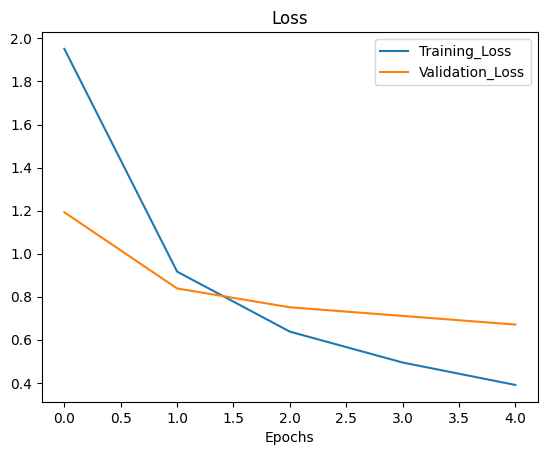

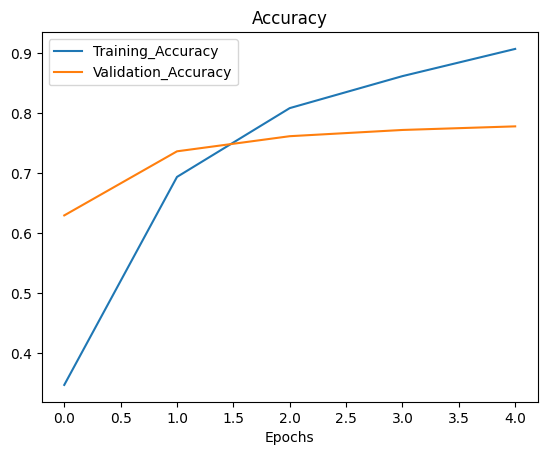

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
efficientnet_model = create_model(model_url=efficientnet_url, num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch= len(train_data_10_percent), validation_data= test_data_10_percent, validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='efficientnet')])

Saving tensorboard log files at: tensorflow_hub/efficientnet/20230516-125800
Epoch 1/5
24/24 [==============================] - 343s 14s/step - loss: 1.8686 - accuracy: 0.4507 - val_loss: 1.2903 - val_accuracy: 0.7388
Epoch 2/5
24/24 [==============================] - 257s 11s/step - loss: 1.0613 - accuracy: 0.7773 - val_loss: 0.8629 - val_accuracy: 0.8328
Epoch 3/5
24/24 [==============================] - 322s 14s/step - loss: 0.7552 - accuracy: 0.8400 - val_loss: 0.6908 - val_accuracy: 0.8488
Epoch 4/5
24/24 [==============================] - 255s 11s/step - loss: 0.6027 - accuracy: 0.8707 - val_loss: 0.6089 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 255s 11s/step - loss: 0.5106 - accuracy: 0.8893 - val_loss: 0.5565 - val_accuracy: 0.8640


In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "Efficientnet vs Resnet" \
--description "Comparing two different TF hub feature extraction models architectures using 10% of training images" \
--one_shot

2023-05-16 13:15:57.840225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   YQBB-HWCX



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

In [21]:
!tensorboard dev list

2023-05-16 13:26:30.950558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/W8Z7EXQsQCW4BG5wZnBfAg/
	Name                 Efficientnet vs Resnet
	Description          Comparing two different TF hub feature extraction models architectures using 10% of training images
	Id                   W8Z7EXQsQCW4BG5wZnBfAg
	Created              2023-05-16 13:23:14 (3 minutes ago)
	Updated              2023-05-16 13:23:17 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5932389
Total: 1 experiment(s)
